<h1>Nasdaq Composite Trading</h1>

<h1><b>Abstract</b></h1>
The Nasdaq Stock Market is an American stock exchange based in New York City. It is ranked second on the list of stock exchanges by market capitalization of shares traded, behind the New York Stock Exchange. The exchange platform is owned by Nasdaq, Inc., which also owns the Nasdaq Nordic stock market network and several U.S. stock and options exchanges.

The <b>Nasdaq Composite (IXIC)</b> is a stock market index that includes almost all stocks listed on the Nasdaq stock exchange. Along with the Dow Jones Industrial Average and S&P 500, it is one of the three most-followed stock market indices in the United States. The composition of the NASDAQ Composite is heavily weighted towards companies in the information technology sector. The Nasdaq-100, which includes 100 of the largest non-financial companies in the Nasdaq Composite, accounts for over 90% of the movement of the Nasdaq Composite.

# Load the Data

In [3]:
import math
import numpy as np 
import pandas as pd 
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates # Formatting dates

#from keras.optimizers import Adam # For detailed configuration of the optimizer *****
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.callbacks import EarlyStopping # EarlyStopping during model training
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from sklearn.preprocessing import RobustScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
from sklearn.metrics import mean_absolute_error, mean_squared_error

today = date.today()
date_today = today.strftime("%Y-%m-%d")                      
date_start = '2000-01-01'

stockname = 'NASDAQ'
symbol = '^IXIC'                                             
df = yf.download(symbol, start=date_start, end=date_today)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-12-31,4056.989990,4082.370117,4032.330078,4069.310059,4069.310059,762980000
2000-01-03,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000
2000-01-04,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000
2000-01-05,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000
2000-01-06,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000
...,...,...,...,...,...,...
2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000
2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000
2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000


# PreProcessing

In [2]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5521 entries, 1999-12-31 to 2021-12-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5521 non-null   float64
 1   High       5521 non-null   float64
 2   Low        5521 non-null   float64
 3   Close      5521 non-null   float64
 4   Adj Close  5521 non-null   float64
 5   Volume     5521 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 301.9 KB


In [4]:
train_df = df.sort_values(by=['Date']).copy()     


date_index = train_df.index                       
date_index_df = pd.DataFrame(date_index) 

train_df.reset_index(inplace=True)                
train_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-12-31,4056.989990,4082.370117,4032.330078,4069.310059,4069.310059,762980000
1,2000-01-03,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000
2,2000-01-04,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000
3,2000-01-05,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000
4,2000-01-06,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000
...,...,...,...,...,...,...,...
5516,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000
5517,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000
5518,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000
5519,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000


In [5]:
print('Any missing value ?',train_df.isnull().values.any())   

Any missing value ? False


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5521 entries, 0 to 5520
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5521 non-null   datetime64[ns]
 1   Open       5521 non-null   float64       
 2   High       5521 non-null   float64       
 3   Low        5521 non-null   float64       
 4   Close      5521 non-null   float64       
 5   Adj Close  5521 non-null   float64       
 6   Volume     5521 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 302.1 KB


In [7]:
train_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5521.000000,5521.000000,5521.000000,5521.000000,5521.000000,5.521000e+03
mean,4240.874993,4269.261520,4208.425591,4240.743036,4240.743036,2.158117e+09
std,3147.850280,3165.012884,3127.627258,3148.458193,3148.458193,9.190087e+08
min,1116.760010,1135.890015,1108.489990,1114.109985,1114.109985,1.494100e+08
25%,2131.669922,2147.909912,2113.590088,2131.330078,2131.330078,1.708930e+09
50%,2810.189941,2827.280029,2784.520020,2805.679932,2805.679932,1.931380e+09
75%,5106.870117,5133.439941,5084.180176,5106.589844,5106.589844,2.230020e+09
max,16120.919922,16212.230469,16017.230469,16057.440430,16057.440430,1.110216e+10


# EDA

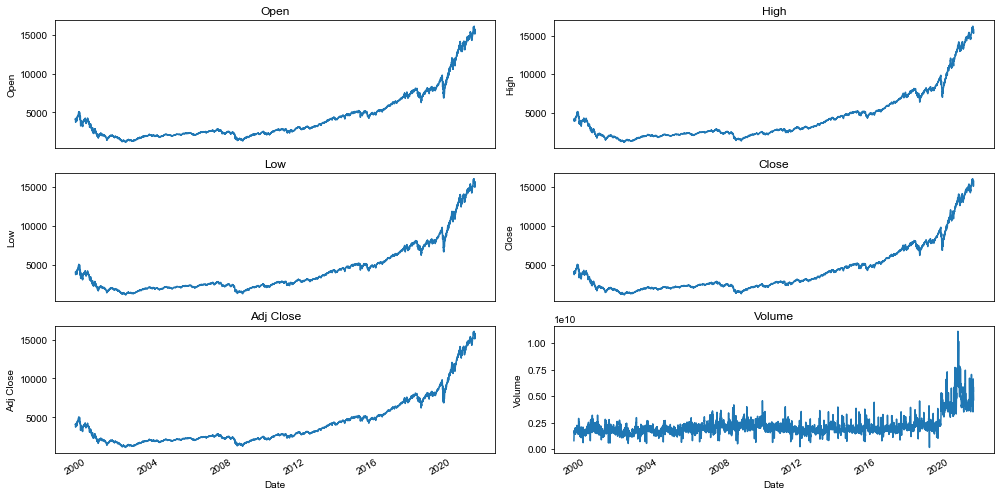

In [8]:
df_plot = df.copy()

list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)                             # Plot lineplots
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

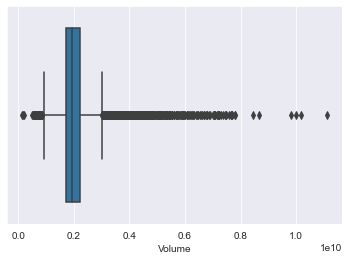

In [9]:
sns.set_style("darkgrid")
sns.boxplot(x = df_plot['Volume']) 
plt.show()

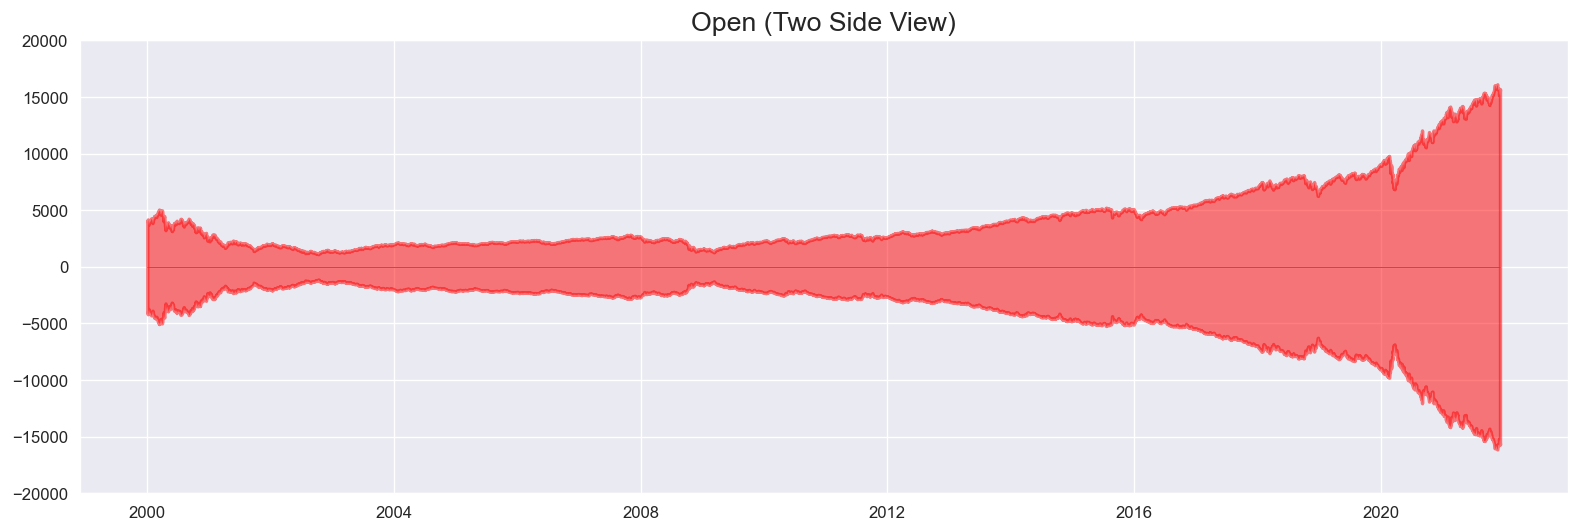

In [10]:
x = train_df['Date'].values
y1 = train_df['Open'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='red')   #Since all values are positive, you can show this on both sides of the Y axis to emphasize the growth.
plt.ylim(-20000, 20000)
plt.title('Open (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(train_df.Date), xmax=np.max(train_df.Date), linewidth=.5)
plt.show()

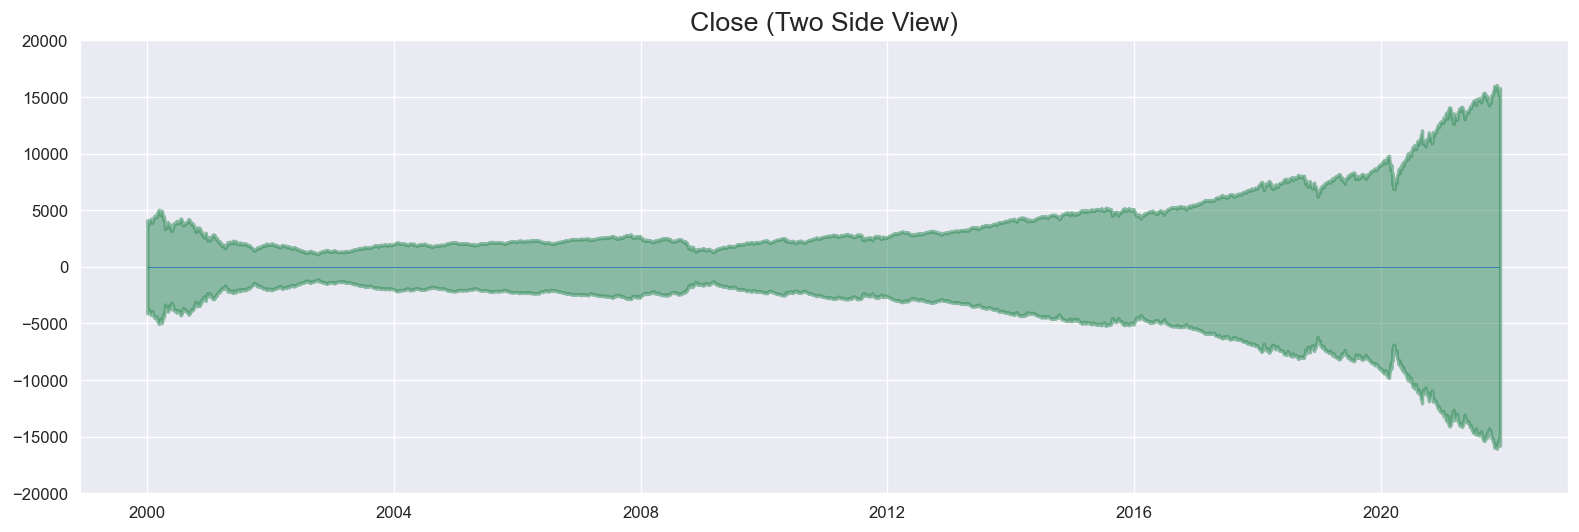

In [11]:
x = train_df['Date'].values
y1 = train_df['Close'].values

fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-20000, 20000)
plt.title('Close (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(train_df.Date), xmax=np.max(train_df.Date), linewidth=.5)
plt.show()

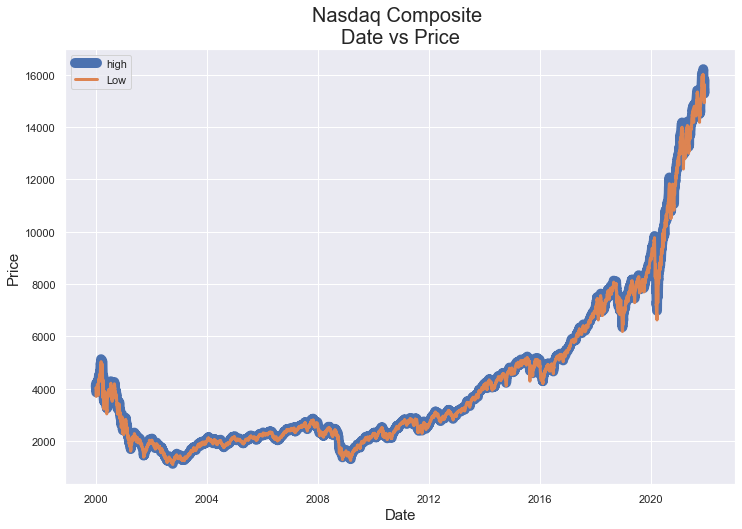

In [12]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12,8))
sns.lineplot(x="Date",y="High",data=train_df,linewidth=10.0,label='high')
sns.lineplot(x="Date",y="Low",data=train_df,linewidth=3.0,label='Low')
plt.xlabel('Date',fontsize=15.0)
plt.ylabel('Price',fontsize=15.0)
plt.title('Nasdaq Composite \nDate vs Price',fontsize=20.0)
plt.legend()
plt.show()

# Feature Engineering

In [13]:
d = pd.to_datetime(train_df.index)
train_df['Day'] = d.strftime("%d")      
train_df['Month'] = d.strftime("%m") 
train_df['Year'] = d.strftime("%Y") 
train_df

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Month,Year
0,1999-12-31,4056.989990,4082.370117,4032.330078,4069.310059,4069.310059,762980000,01,01,1970
1,2000-01-03,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000,01,01,1970
2,2000-01-04,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000,01,01,1970
3,2000-01-05,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000,01,01,1970
4,2000-01-06,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000,01,01,1970
...,...,...,...,...,...,...,...,...,...,...
5516,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000,01,01,1970
5517,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000,01,01,1970
5518,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000,01,01,1970
5519,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000,01,01,1970


In [14]:
def createFeatures(df):
    df = pd.DataFrame(df)

    
    df['Close_Diff'] = df['Adj Close'].diff()
        
    
    df['MA200'] = df['Close'].rolling(window=200).mean() 
    df['MA100'] = df['Close'].rolling(window=100).mean() 
    df['MA50'] = df['Close'].rolling(window=50).mean() 
    df['MA26'] = df['Close'].rolling(window=26).mean()            # Moving averages - different periods
    df['MA20'] = df['Close'].rolling(window=20).mean() 
    df['MA12'] = df['Close'].rolling(window=12).mean() 
    
    
    df['DIFF-MA200-MA50'] = df['MA200'] - df['MA50']
    df['DIFF-MA200-MA100'] = df['MA200'] - df['MA100']
    df['DIFF-MA200-CLOSE'] = df['MA200'] - df['Close']            # SMA Differences - different periods
    df['DIFF-MA100-CLOSE'] = df['MA100'] - df['Close']
    df['DIFF-MA50-CLOSE'] = df['MA50'] - df['Close']
    
    
    df['MA200_low'] = df['Low'].rolling(window=200).min()
    df['MA14_low'] = df['Low'].rolling(window=14).min()
    df['MA200_high'] = df['High'].rolling(window=200).max()       # Moving Averages on high, lows, and std - different periods
    df['MA14_high'] = df['High'].rolling(window=14).max()
    df['MA20dSTD'] = df['Close'].rolling(window=20).std() 
    
   
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()   # Exponential Moving Averages (EMAS) - different periods
    df['EMA100'] = df['Close'].ewm(span=100, adjust=False).mean()
    df['EMA200'] = df['Close'].ewm(span=200, adjust=False).mean()

    
    df['close_shift-1'] = df.shift(-1)['Close']
    df['close_shift-2'] = df.shift(-2)['Close']                   # Shifts (one day before and two days before)

    
    df['Bollinger_Upper'] = df['MA20'] + (df['MA20dSTD'] * 2)    
    df['Bollinger_Lower'] = df['MA20'] - (df['MA20dSTD'] * 2)     # Bollinger Bands
    
    
    df['K-ratio'] = 100*((df['Close'] - df['MA14_low']) / (df['MA14_high'] - df['MA14_low']) )
    df['RSI'] = df['K-ratio'].rolling(window=3).mean()            # Relative Strength Index (RSI)
 
    
    df['MACD'] = df['EMA12'] - df['EMA26']                        # Moving Average Convergence/Divergence (MACD)
    
    
    nareplace = df.at[df.index.max(), 'Close']                    # Replace NA's 
    df.fillna((nareplace), inplace=True)
    
    return df

In [15]:
FEATURES = [
#             'High',
#             'Low',
#             'Open',
              'Close',
#             'Volume',
              'Date',
#             'Day',
#             'Month',
#             'Year',
#             'Adj Close',
#             'close_shift-1',
#             'close_shift-2',
              'MACD',
              'RSI',
#             'MA200',
#             'MA200_high',
#             'MA200_low',
              'Bollinger_Upper',                                      # List of considered Features
              'Bollinger_Lower',
#             'MA100',            
#             'MA50',
#             'MA26',
#             'MA14_low',
#             'MA14_high',
#             'MA12',
#             'EMA20',
#             'EMA100',
#             'EMA200',
#             'DIFF-MA200-MA50',
#             'DIFF-MA200-MA10',
#             'DIFF-MA200-CLOSE',
#             'DIFF-MA100-CLOSE',
#             'DIFF-MA50-CLOSE'
           ]


# Short Term Analysis

             Close       Date       MACD        RSI  Bollinger_Upper  Bollinger_Lower    Prediction
5516  15381.320312 2021-12-02  31.162609  11.385320     16225.724148     15343.461985  15381.320312
5517  15085.469727 2021-12-03 -14.349003  11.621804     16275.423396     15208.278753  15085.469727
5518  15225.150391 2021-12-06 -38.700110  18.925039     16273.676822     15135.381381  15225.150391
5519  15686.919922 2021-12-07 -20.501271  31.334912     16243.674989     15135.839172  15686.919922
5520  15786.990234 2021-12-08   1.973529  49.586979     16233.012009     15136.547171  15786.990234


<function matplotlib.pyplot.show(close=None, block=None)>

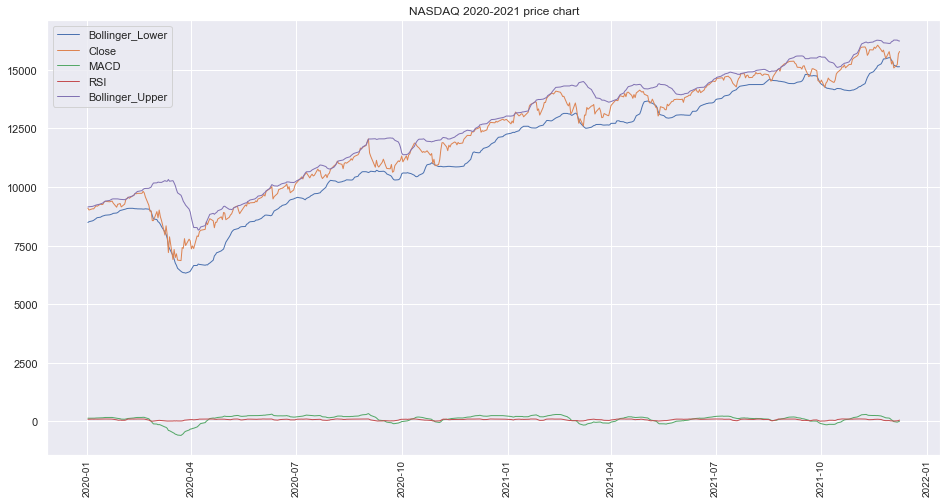

In [16]:
data = createFeatures(train_df)                               # Dataset with features

use_start_date = pd.to_datetime("2020-01-01" )
data = data[data['Date'] > use_start_date].copy()             # Shift the timeframe

data_filtered = data[FEATURES]                                # Filter the data to the list of FEATURES


data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']  # We add a prediction column and set dummy values to prepare the data for scaling
print(data_filtered_ext.tail().to_string())

dfs = data_filtered_ext.copy()
del dfs[('Date')]                                             # remove Date column before training 
del dfs[('Prediction')]

# Register matplotlib converters
register_matplotlib_converters()

nrows = dfs.shape[1]
fig, ax = plt.subplots(figsize=(16, 8))                       # Plot parameters
x = data_filtered_ext['Date'] 
assetname_list = []

for i in range(nrows):
    assetname = dfs.columns[i-1]
    y = data_filtered_ext[assetname]
    ax.plot(x, y, label=assetname, linewidth=1.0)             # Plotting each column
    assetname_list.append(assetname)

# Configure and show the plot    
ax.set_title(stockname + ' 2020-2021 price chart')
ax.legend()
ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)   
plt.show

# Long Term Analysis

             Close       Date       MACD        RSI  Bollinger_Upper  Bollinger_Lower    Prediction
5516  15381.320312 2021-12-02  31.162609  11.385320     16225.724148     15343.461985  15381.320312
5517  15085.469727 2021-12-03 -14.349003  11.621804     16275.423396     15208.278753  15085.469727
5518  15225.150391 2021-12-06 -38.700110  18.925039     16273.676822     15135.381381  15225.150391
5519  15686.919922 2021-12-07 -20.501271  31.334912     16243.674989     15135.839172  15686.919922
5520  15786.990234 2021-12-08   1.973529  49.586979     16233.012009     15136.547171  15786.990234


<function matplotlib.pyplot.show(close=None, block=None)>

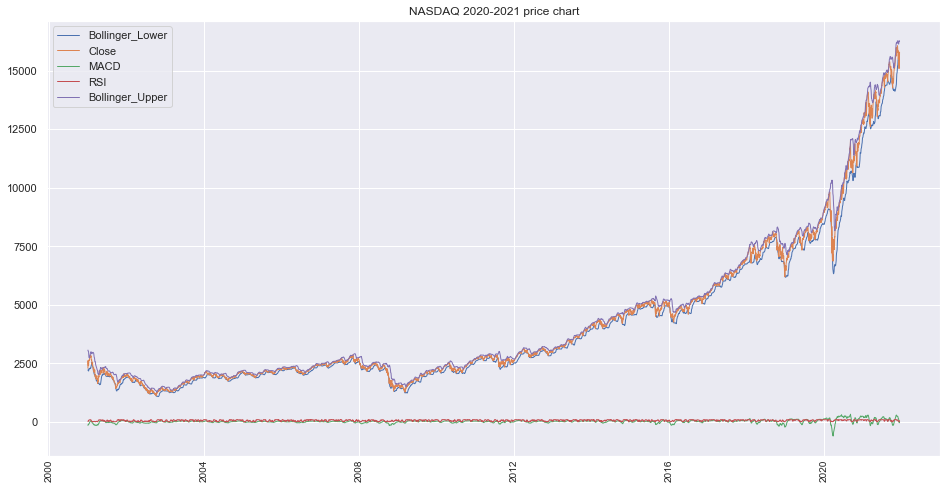

In [17]:
data = createFeatures(train_df)                               # Dataset with features

use_start_date = pd.to_datetime("2001-01-01" )
data = data[data['Date'] > use_start_date].copy()             # Shift the timeframe

data_filtered = data[FEATURES]                                # Filter the data to the list of FEATURES


data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']  # We add a prediction column and set dummy values to prepare the data for scaling
print(data_filtered_ext.tail().to_string())

dfs = data_filtered_ext.copy()
del dfs[('Date')]                                             # remove Date column before training 
del dfs[('Prediction')]

# Register matplotlib converters
register_matplotlib_converters()

nrows = dfs.shape[1]
fig, ax = plt.subplots(figsize=(16, 8))                       # Plot parameters
x = data_filtered_ext['Date'] 
assetname_list = []

for i in range(nrows):
    assetname = dfs.columns[i-1]
    y = data_filtered_ext[assetname]
    ax.plot(x, y, label=assetname, linewidth=1.0)             # Plotting each column
    assetname_list.append(assetname)

# Configure and show the plot    
ax.set_title(stockname + ' 2020-2021 price chart')
ax.legend()
ax.tick_params(axis="x", rotation=90, labelsize=10, length=0)   
plt.show

# Hypothesis Testing

In [2]:
df_h = df.copy()
df_h = df_h.reset_index()
df_h

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-12-31,4056.989990,4082.370117,4032.330078,4069.310059,4069.310059,762980000
1,2000-01-03,4186.189941,4192.189941,3989.709961,4131.149902,4131.149902,1510070000
2,2000-01-04,4020.000000,4073.250000,3898.229980,3901.689941,3901.689941,1511840000
3,2000-01-05,3854.350098,3924.209961,3734.870117,3877.540039,3877.540039,1735670000
4,2000-01-06,3834.439941,3868.760010,3715.620117,3727.129883,3727.129883,1598320000
...,...,...,...,...,...,...,...
5516,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000
5517,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000
5518,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000
5519,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000


Text(0, 0.5, 'Volume')

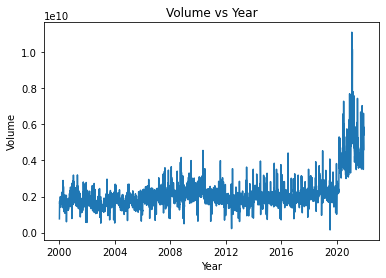

In [3]:
plt.plot(df['Volume'])
plt.title('Volume vs Year')
plt.xlabel('Year')
plt.ylabel('Volume')

In [4]:
h1 = df_h['Volume'].values

In [5]:
import random
values =(random.sample(list(h1), 500))
values

[3814100000,
 1774570000,
 2702070000,
 2084950000,
 1658570000,
 1587980000,
 1734970000,
 4151190000,
 1749530000,
 2075000000,
 1440300000,
 2610680000,
 1583710000,
 1824530000,
 1383530000,
 1620690000,
 1779320000,
 1564340000,
 2841130000,
 5412610000,
 4314980000,
 1492720000,
 1501360000,
 1957070000,
 1435190000,
 2172030000,
 1585090000,
 1983190000,
 1931870000,
 1710000000,
 1458030000,
 2232340000,
 1233190000,
 1682590000,
 1810400000,
 2316710000,
 1813150000,
 1130450000,
 1804950000,
 1833070000,
 1879350000,
 2223560000,
 4507040000,
 2526040000,
 1495030000,
 4330610000,
 1751060000,
 2575240000,
 1845230000,
 1795680000,
 4273890000,
 1903210000,
 2137080000,
 1508530000,
 2166470000,
 1319250000,
 2024600000,
 1736890000,
 2011010000,
 1784220000,
 1995130000,
 1714140000,
 1444780000,
 2198050000,
 1237350000,
 10000200000,
 1844790000,
 2109940000,
 1869690000,
 2611690000,
 592760000,
 1852360000,
 1894210000,
 1940470000,
 3661710000,
 2408320000,
 1839490000,

In [6]:
average = round(sum(values)/len(values))
average

2197980400

In [7]:
h0 = round(df_h['Volume'].mean())
h0

2158116573

Null hypothesis: Average volume traded in day is 2158116573

Alternate hypothesis: Average volume traded in day > 2158116573

In [9]:
import scipy.stats
import statistics
sample_cured=values
alpha=0.1
z_critical=scipy.stats.norm.ppf(1-alpha)
Mu=statistics.mean(h1)
xbar=statistics.mean(sample_cured)
n=len(values)
std=h1.std()
z=(xbar-Mu)/(std/np.sqrt(n))
print(z," ",z_critical)
if(z<z_critical):
    print("Null Hyothesis Accepted")
else:
    print("Alternate hypothesis accepted")

0.9700267182856757   1.2815515655446004
Null Hyothesis Accepted


In [10]:
h2 = df_h[pd.DatetimeIndex(df_h['Date']).year == 2020]['Close'].values
h2

array([ 9092.19042969,  9020.76953125,  9071.46972656,  9068.58007812,
        9129.24023438,  9203.4296875 ,  9178.86035156,  9273.9296875 ,
        9251.33007812,  9258.70019531,  9357.12988281,  9388.94042969,
        9370.80957031,  9383.76953125,  9402.48046875,  9314.91015625,
        9139.30957031,  9269.6796875 ,  9275.16015625,  9298.9296875 ,
        9150.94042969,  9273.40039062,  9467.96972656,  9508.6796875 ,
        9572.15039062,  9520.50976562,  9628.38964844,  9638.94042969,
        9725.95996094,  9711.96972656,  9731.1796875 ,  9732.74023438,
        9817.1796875 ,  9750.96972656,  9576.58984375,  9221.28027344,
        8965.61035156,  8980.78027344,  8566.48046875,  8567.37011719,
        8952.16992188,  8684.08984375,  9018.08984375,  8738.58984375,
        8575.62011719,  7950.68017578,  8344.25      ,  7952.04980469,
        7201.79980469,  7874.87988281,  6904.58984375,  7334.77978516,
        6989.83984375,  7150.58007812,  6879.52001953,  6860.66992188,
      

In [11]:
h2_values =(random.sample(list(h2), 100))
average = round(sum(h2_values)/len(h2_values))
average

10191

In [12]:
h0 = statistics.mean(h2)
h0

10201.506434504694

<p>Null hypothesis: Average trading volume in 2020 is 10201</p>
<p>Alternate hypothesis : Average trading volume in 2020 < 10201</p>

In [13]:
import scipy.stats
import statistics
sample_cured=h2_values
alpha=0.1
z_critical=scipy.stats.norm.ppf(1-alpha)
Mu=statistics.mean(h2)
xbar=statistics.mean(sample_cured)
n=len(h2_values)
std=h2.std()
z=(xbar-Mu)/(std/np.sqrt(n))
print(z," ",z_critical)
if(z<z_critical):
    print("Null Hyothesis Accepted")
else:
    print("Alternate hypothesis accepted")

-0.07019620382380337   1.2815515655446004
Null Hyothesis Accepted


# Scaling and Transforming the Data

In [25]:
nrows = dfs.shape[0]
np_data_unscaled = np.reshape(np.array(dfs), (nrows, -1))
print(np_data_unscaled.shape)

scaler = RobustScaler()
np_data = scaler.fit_transform(np_data_unscaled)

scaler_pred = RobustScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(5268, 5)


In [26]:
sequence_length = 50

train_data_length = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[0:train_data_length, :]
test_data = np_Close_scaled[train_data_length - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, 0]) 
    
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(x_train[1][sequence_length-1][0])
print(y_train[0])

(4165, 50, 1) (4165,)
(1053, 50, 1) (1053,)
-0.2527193861022734
-0.2527193861022734


# Model Training

timesteps: 50, features:1
Parameters: ['epochs 100', 'batch_size 32', 'patience 6', 'optimizer adam with learn rate 0.05', 'loss mean_squared_error']
Epoch 1/100
131/131 [==============================] - 13s 48ms/step - loss: 0.0457 - val_loss: 0.7593
Epoch 2/100
131/131 [==============================] - 5s 38ms/step - loss: 0.0374 - val_loss: 0.5429
Epoch 3/100
131/131 [==============================] - 5s 38ms/step - loss: 0.0374 - val_loss: 0.3871
Epoch 4/100
131/131 [==============================] - 5s 38ms/step - loss: 0.0374 - val_loss: 0.4026
Epoch 5/100
131/131 [==============================] - 5s 37ms/step - loss: 0.0373 - val_loss: 0.3510
Epoch 6/100
131/131 [==============================] - 5s 38ms/step - loss: 0.0374 - val_loss: 0.3733
Epoch 7/100
131/131 [==============================] - 5s 39ms/step - loss: 0.0373 - val_loss: 0.2268
Epoch 8/100
131/131 [==============================] - 5s 40ms/step - loss: 0.0373 - val_loss: 0.1971
Epoch 9/100
131/131 [============

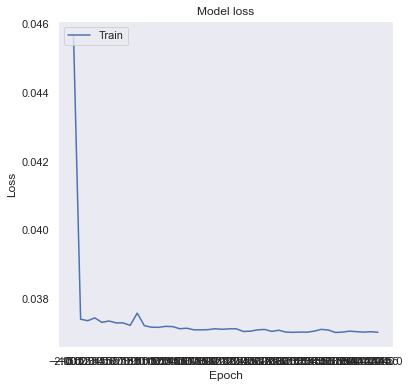

In [27]:
model = Sequential()

n_neurons = x_train.shape[1] * x_train.shape[2]
print('timesteps: ' + str(x_train.shape[1]) + ',' + ' features:' + str(x_train.shape[2]))
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 

model.add(LSTM(n_neurons, return_sequences=True))

model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1, activation='relu'))
 
optimizer='adam'; loss='mean_squared_error'; epochs = 100; batch_size = 32; patience = 6;

parameter_list = ['epochs ' + str(epochs), 'batch_size ' + str(batch_size), 'patience ' + str(patience), 'optimizer ' + str(optimizer), 'loss ' + str(loss)]
print('Parameters: ' + str(parameter_list))


model.compile(optimizer=optimizer, loss=loss)
early_stop = EarlyStopping(monitor='loss', patience=patience, verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], shuffle = True,
                  validation_data=(x_test, y_test))


fig, ax = plt.subplots(figsize=(6, 6), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,465
Trainable params: 52,465
Non-trainable params: 0
_________________________________________________________________


# Model Performance

Median Absolute Error (MAE): 567.81
Mean Absolute Percentage Error (MAPE): 4.42 %
Median Absolute Percentage Error (MDAPE): 1.57 %


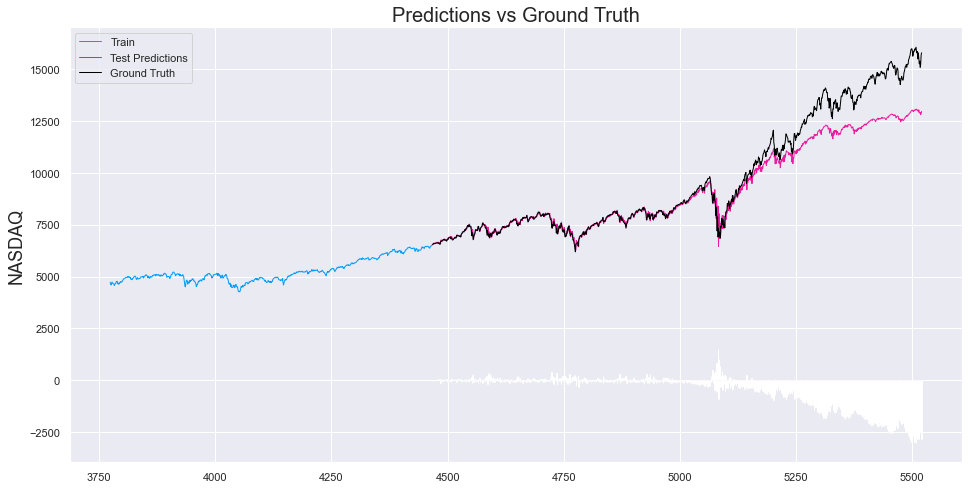

In [28]:
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled.shape

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

display_start_date = "2015-01-01" 

data_filtered_sub = data_filtered.copy()

date_index = date_index_df[date_index_df['Date'] > use_start_date].copy()
data_filtered_sub['Date'] = date_index

train = data_filtered_sub[:train_data_length + 1]
valid = data_filtered_sub[train_data_length:]
valid.insert(1, "Predictions", y_pred, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)


valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

fig, ax = plt.subplots(figsize=(16, 8), sharex=True)

plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(train["Close"], color="#039dfc", linewidth=1.0)
plt.plot(valid["Predictions"], color="#E91D9E", linewidth=1.0)
plt.plot(valid["Close"], color="black", linewidth=1.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

valid.loc[valid["Difference"] >= 0, 'diff_color'] = "#2BC97A"
valid.loc[valid["Difference"] < 0, 'diff_color'] = "#C92B2B"
plt.bar(valid.index, valid["Difference"], width=0.8, color=valid['diff_color'])

plt.show()

# Trade Trend Prediction (Gradient Boosting)

In [4]:
df = df.reset_index()
df = df[df['Date'] >= '2012-01-01']
df.set_index('Date', inplace = True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1636850000
2012-01-04,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1670530000
2012-01-05,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1836410000
2012-01-06,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1683090000
2012-01-09,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1768080000
...,...,...,...,...,...,...
2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000
2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000
2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000


In [5]:
df = df.reset_index()
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1636850000
1,2012-01-04,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1670530000
2,2012-01-05,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1836410000
3,2012-01-06,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1683090000
4,2012-01-09,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1768080000
...,...,...,...,...,...,...,...
2496,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000
2497,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000
2498,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000
2499,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000


In [6]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1636850000
1,2012-01-04,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1670530000
2,2012-01-05,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1836410000
3,2012-01-06,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1683090000
4,2012-01-09,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1768080000
...,...,...,...,...,...,...,...
2496,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000
2497,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000
2498,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000
2499,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000


<AxesSubplot:xlabel='Date'>

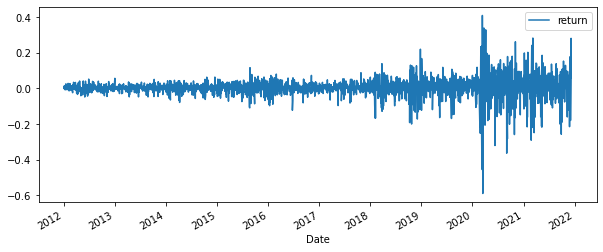

In [7]:
# Normalize aclose value
# We use this value to train model

df['return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(x='Date', y='return', figsize=(10,4))

In [8]:
# Make label, 1 as rising price, 0 as falling price

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
2496,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000,0.077445,0
2497,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000,-0.180027,1
2498,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000,0.084996,1
2499,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000,0.280989,1
2500,2021-12-08,15690.650391,15792.639648,15618.879883,15786.990234,15786.990234,4600800000,0.060893,0


In [9]:
df1 = df[df['label'] == 1]
df2 = df[df['label'] == 0]

In [10]:
print('df1 ',df1.shape)
print('df2 ',df2.shape)

df1  (1413, 9)
df2  (1088, 9)


In [11]:
df1 =df1.sample(n=1088)
df1

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
1375,2017-06-21,6202.750000,6236.660156,6200.859863,6233.950195,6233.950195,2401440000,0.027943,1
983,2015-11-30,5139.580078,5141.359863,5098.700195,5108.669922,5108.669922,2244550000,-0.011470,1
963,2015-10-30,5079.759766,5085.220215,5053.750000,5053.750000,5053.750000,2016390000,-0.012487,1
2034,2020-02-04,9398.389648,9485.379883,9374.049805,9467.969727,9467.969727,2445420000,0.118397,1
64,2012-04-04,3085.459961,3086.350098,3052.580078,3068.090088,3068.090088,1813150000,-0.027675,1
...,...,...,...,...,...,...,...,...,...
375,2013-07-02,3430.689941,3453.290039,3415.229980,3433.399902,3433.399902,1685190000,-0.000663,1
320,2013-04-15,3277.580078,3283.399902,3213.459961,3216.489990,3216.489990,1779320000,-0.047743,1
418,2013-09-03,3622.639893,3637.060059,3593.620117,3612.610107,3612.610107,1628810000,0.013837,1
1539,2018-02-14,6979.240234,7152.049805,6977.069824,7143.620117,7143.620117,2211460000,0.079173,1


In [12]:
df_merge = pd.concat([df1, df2])
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
1375,2017-06-21,6202.750000,6236.660156,6200.859863,6233.950195,6233.950195,2401440000,0.027943,1
983,2015-11-30,5139.580078,5141.359863,5098.700195,5108.669922,5108.669922,2244550000,-0.011470,1
963,2015-10-30,5079.759766,5085.220215,5053.750000,5053.750000,5053.750000,2016390000,-0.012487,1
2034,2020-02-04,9398.389648,9485.379883,9374.049805,9467.969727,9467.969727,2445420000,0.118397,1
64,2012-04-04,3085.459961,3086.350098,3052.580078,3068.090088,3068.090088,1813150000,-0.027675,1
...,...,...,...,...,...,...,...,...,...
2491,2021-11-24,15677.879883,15848.559570,15591.360352,15845.230469,15845.230469,4178630000,0.042651,0
2493,2021-11-29,15719.419922,15833.110352,15644.610352,15782.830078,15782.830078,4800570000,0.177179,0
2494,2021-11-30,15716.500000,15828.200195,15451.389648,15537.690430,15537.690430,6609380000,-0.149169,0
2496,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000,0.077445,0


In [13]:
df_merge = df_merge.sort_values("Date")
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
0,2012-01-03,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1636850000,NaN,0
1,2012-01-04,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1670530000,-0.000219,1
3,2012-01-06,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1683090000,0.002653,1
4,2012-01-09,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1768080000,0.001424,1
7,2012-01-12,2716.870117,2726.429932,2697.320068,2724.699951,2724.699951,1669550000,0.008483,0
...,...,...,...,...,...,...,...,...,...
2495,2021-12-01,15752.269531,15816.820312,15243.929688,15254.049805,15254.049805,6266020000,-0.172597,1
2496,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000,0.077445,0
2497,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000,-0.180027,1
2498,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000,0.084996,1


In [14]:
df_merge.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
return       1
label        0
dtype: int64

In [15]:
df_merge.drop(index=df_merge.index[0], axis=0,inplace=True)

In [16]:
df_merge.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
return       0
label        0
dtype: int64

In [17]:
df_merge.set_index('Date',inplace = True)
df_merge.reset_index(inplace = True)
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
0,2012-01-04,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1670530000,-0.000219,1
1,2012-01-06,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1683090000,0.002653,1
2,2012-01-09,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1768080000,0.001424,1
3,2012-01-12,2716.870117,2726.429932,2697.320068,2724.699951,2724.699951,1669550000,0.008483,0
4,2012-01-13,2707.409912,2712.929932,2689.580078,2710.669922,2710.669922,1655960000,-0.008537,1
...,...,...,...,...,...,...,...,...,...
2170,2021-12-01,15752.269531,15816.820312,15243.929688,15254.049805,15254.049805,6266020000,-0.172597,1
2171,2021-12-02,15181.820312,15444.540039,15150.120117,15381.320312,15381.320312,5390100000,0.077445,0
2172,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000,-0.180027,1
2173,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000,0.084996,1


In [18]:
# Make training dataset

n_features = 60 # number of features or taking last 60 days for each  tree

train_x = np.array([]).reshape([-1,n_features]) #empty array of size 60
train_y = np.array([]).reshape([-1,1])
for index, row in df_merge.iterrows():
    i = df_merge.index.get_loc(index)  #index
    if i<n_features:
        continue
    
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1]) #taking 60 entries
    _y = df_merge.loc[i]['label']
    train_x = np.vstack((train_x, _x))    #vertical stacking
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(2115, 60)
(2115,)
% of Class0 : 0.500236
% of Class1 : 0.499764


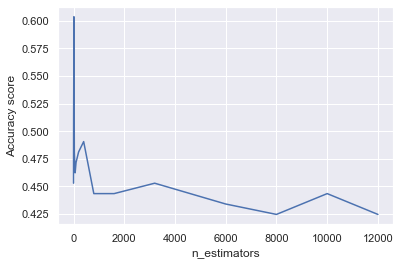

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
acc_score = []
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200, 400, 800, 1600, 3200, 6000, 8000, 10000, 12000]
for i in n_estimators:
    clf = GradientBoostingClassifier(n_estimators=i, random_state=0)
    train_len = int(len(train_x)*0.95)
    clf.fit(train_x[:train_len], train_y[:train_len])

    predicted_values = clf.predict(train_x[train_len:])

    x = metrics.accuracy_score(train_y[train_len:], predicted_values)
    acc_score.append(x) 
    
plt.plot(n_estimators, acc_score, 'b', label='Accuracy')
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

In [19]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, n_estimators=4)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.528302


,return,label,pred,won,pnl,equity
100,81.109375,0.0,1.0,False,-8.110938e+05,-4.460977e+06
101,-64.379883,1.0,1.0,True,6.437988e+05,-3.817178e+06
102,118.490234,0.0,1.0,False,-1.184902e+06,-5.002080e+06
103,46.849609,1.0,1.0,True,4.684961e+05,-4.533584e+06
104,67.919922,1.0,0.0,False,-6.791992e+05,-5.212783e+06


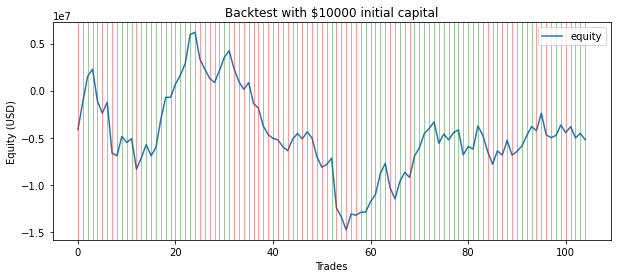

In [20]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']          #comparing prediction and actual
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission       #net p&l for all the contracts
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')


Number Winning Trades : 56
Number Losing Trades  : 49
Percent Profitable    : 53.33%
Avg Win Trade         : $1158550.415
Avg Los Trade         : $-1430440.948
Largest Win Trade     : $3069794.922
Largest Los Trade     : $-5401601.562
Profit Factor         : 0.93


<AxesSubplot:>

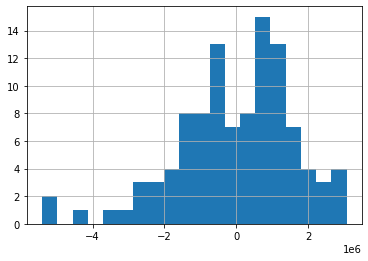

In [22]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(train_y[train_len:], pred))

              precision    recall  f1-score   support

         0.0       0.47      0.51      0.49        47
         1.0       0.58      0.54      0.56        59

    accuracy                           0.53       106
   macro avg       0.53      0.53      0.53       106
weighted avg       0.53      0.53      0.53       106

